# Analyzing NYC High School Data

In this project we will explore the efficiency and dependencies of a Scholastic Aptitude Test for school of New York City. For that purpose we will use next data sources.

* ap_2010.csv - Data on AP test results
* class_size.csv - Data on class size
* demographics.csv - Data on demographics
* graduation.csv - Data on graduation outcomes
* hs_directory.csv - A directory of high schools
* sat_results.csv - Data on SAT scores
* survey_all.txt - Data on surveys from all schools
* survey_d75.txt - Data on surveys from New York City district 75

We will read them, combine in one dataset, clean empty and wrong data from it and then research it.  

# Read in the data

In [2]:
import pandas as pd
import numpy
import re

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d
    


# Read in the surveys

In [3]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0, sort=True)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"].sort_values(ascending=False)

# Plotting survey correlations

In [11]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

# Correlation between SAT score and survey results

In [13]:
import matplotlib as plt
survey_correlations = correlations.loc[survey_fields]

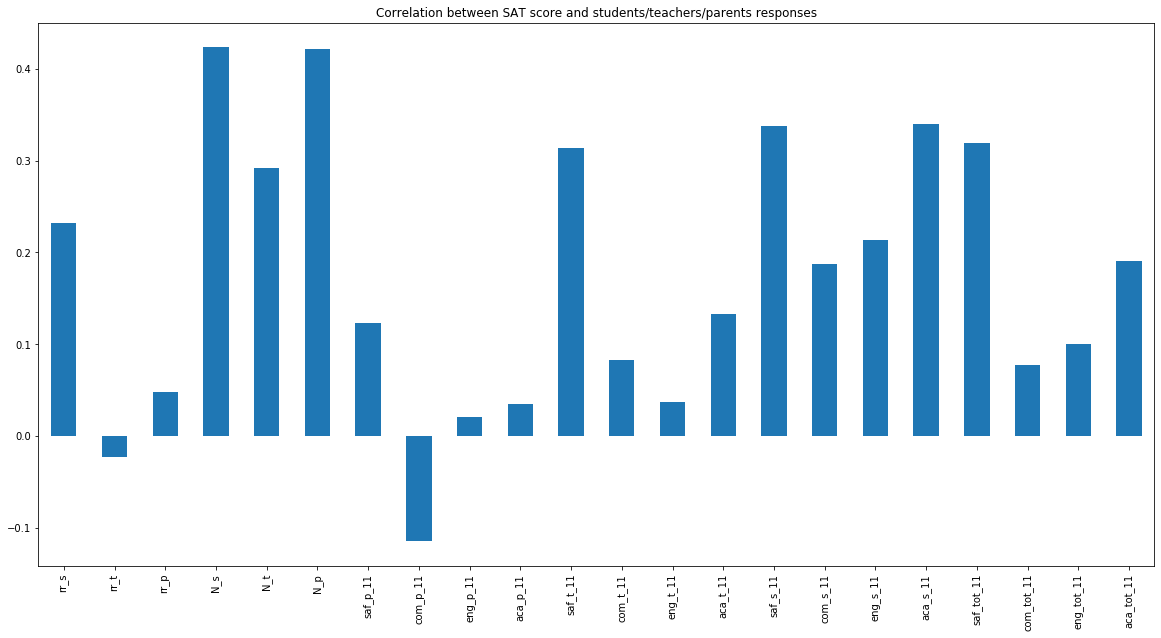

In [72]:
survey_correlations.plot(x=survey_correlations.values, y=survey_correlations.index, kind='bar', figsize=(20, 10), title='Correlation between SAT score and students/teachers/parents responses')

At first we see the strong correlation between SAT score (sat_score) and number of respondents (rr_s, rr_t, rr_p). Big number of respondents is correlated with total enrollment so that values should be high.

It is more interesting that rr_s, the student response rate, or rr_p, the percentage of students that completed the survey, correlates with SAT score. This might make sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.

Then we see Safety and Respect score based on teacher and student responses (saf_t_11, saf_s_11). It's obvious result, because high level of safety and respect helps teachers to teach their students more effectively and students acquire knowledge more easily.  

Next interesting correlation is the Academic Expectations student score (aca_s_11), which indicates how the student perceives academic standards, correlates with SAT score, but this is not true for Academic Expectations teacher score (aca_t_11) or Academic Expectations parent score (aca_t_11).

There is also strong correlation between SAT and student engagement scores (eng_s_11). This makes sense, because well conducted school engagements let students to study more effectively. 

Last interesting correlation is student communication score (com_s_11). Apperently if students can easely communicate with another students and discuss or ask questions about educational material, it helps them to learn.

Let's dig into relationship between SAT score and safety scores (saf_t_11, saf_s_11).

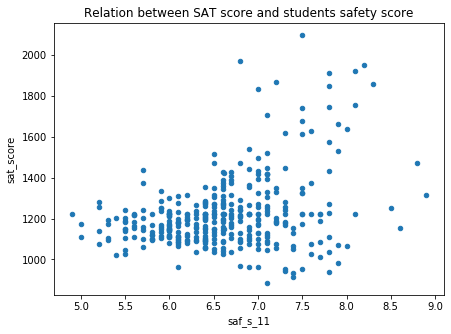

In [73]:
combined.plot(x='saf_s_11', y='sat_score', kind='scatter', figsize=(7, 5), title='Relation between SAT score and students safety score')

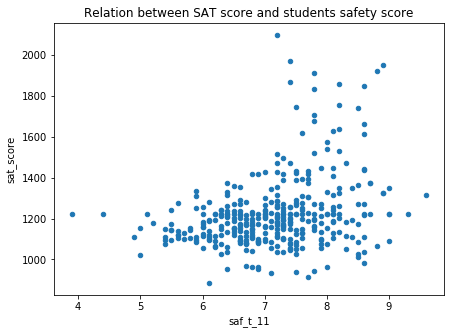

In [74]:
combined.plot(x='saf_t_11', y='sat_score', kind='scatter', figsize=(7, 5), title='Relation between SAT score and students safety score')

On both plots, which resemble relation between SAT score and safety scores for students and teacher we can clearly see a trend line which is directed from field with low SAT score and low safety score to field with high SAT score and high safety. It confirms our theory about direct connection between high SAT score and safety level at school.

# Safety of districts and boroughs

We group dataset by districts and boroughs, compute average safety rating for them and visualize difference between them.

In [17]:
districts=combined.groupby('school_dist').agg(numpy.mean)
districts.reset_index(inplace=True)
districts.head()

,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO,schoolyear,fl_percent,frl_percent,total_enrollment,ell_num,ell_percent,sped_num,sped_percent,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,aca_p_11,saf_t_11,com_t_11,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
0,01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,1.0,115.244241,5.148538,22.675415,18.798392,26.553044,0.0,20112012.0,0.0,58.983333,668.500000,42.166667,10.000000,82.000000,17.083333,134.500000,17.516667,125.500000,22.333333,214.833333,40.733333,186.000000,18.450000,328.166667,50.050000,340.333333,49.950000,76.500000,85.333333,33.166667,525.368056,38.500000,239.166667,8.233333,7.800000,7.683333,8.016667,7.066667,6.233333,6.700000,7.500000,6.768611,6.165787,6.736713,7.446898,7.433333,6.816667,7.116667,7.683333,12.0,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377
1,02,426.619092,444.186256,424.832836,1295.638184,128.908454,201.516827,157.495833,158.647849,2.0,149.818949,5.686360,25.038118,20.662667,28.593861,0.0,20112012.0,0.0,63.164583,605.604167,51.625000,13.006250,70.770833,13.212500,118.395833,14.479167,141.145833,24.733333,271.458333,49.554167,68.541667,10.056250,266.500000,44.718750,339.104167,55.281250,83.312500,86.416667,38.333333,495.171007,31.687500,190.000000,8.254167,7.495833,7.379167,7.704167,7.404167,6.520833,7.120833,7.564583,6.910660,6.204057,6.650422,7.385029,7.520833,6.720833,7.037500,7.541667,12.0,12.0,10023.770833,621.395833,1.416667,0.0,0.0,0.0,40.739699,-73.991386
2,03,428.529851,437.997512,426.915672,1293.443035,156.183494,244.522436,193.087500,183.384409,3.0,156.005994,5.839200,23.716311,19.737593,27.122831,0.0,20112012.0,0.0,58.050000,661.416667,36.916667,9.025000,63.583333,14.500000,68.000000,6.408333,181.833333,34.000000,228.250000,44.533333,172.000000,13.725000,272.166667,47.950000,389.250000,52.050000,83.166667,80.833333,36.166667,519.250000,28.166667,206.416667,8.316667,7.541667,7.508333,7.758333,6.675000,5.991667,6.533333,6.991667,6.716667,6.258333,6.633333,7.375000,7.233333,6.616667,6.891667,7.391667,12.0,12.0,10023.750000,717.916667,2.000000,0.0,0.0,0.0,40.781574,-73.977370
3,04,402.142857,416.285714,405.714286,1224.142857,129.016484,183.879121,151.035714,113.857143,4.0,132.362265,5.192610,24.101048,19.740816,27.460291,0.0,20112012.0,0.0,71.000000,569.285714,21.571429,4.557143,58.571429,13.214286,61.142857,6.128571,151.714286,30.028571,341.571429,61.400000,9.285714,1.314286,193.285714,30.514286,376.000000,69.485714,87.571429,92.714286,41.285714,504.857143,32.428571,193.142857,8.385714,7.657143,7.500000,7.928571,7.871429,7.042857,7.428571,7.885714,6.885714,6.114286,6.685714,7.571429,7.714286,6.942857,7.185714,7.785714,12.0,12.0,10029.857143,580.857143,1.142857,0.0,0.0,0.0,40.793449,-73.943215
4,05,427.159915,438.236674,419.666098,1285.062687,85.722527,115.725275,142.464286,143.677419,5.0,120.623901,4.845101,24.290247,20.447527,27.746703,0.0,20112012.0,0.0,58.671429,605.857143,21.571429,4.157143,59.714286,10.428571,32.714286,7.300000,342.571429,49.000000,195.571429,36.214286,31.285714,6.714286,300.000000,48.471429,305.857143,51.528571,82.857143,79.285714,40.428571,442.428571,27.714286,184.857143,8.085714,7.342857,7.357143,7.685714,6.857143,5.885714,6.242857,6.957143,6.314286,6.000000,6.428571,7.285714,7.085714,6.414286,6.671429,7.314286,12.0,12.0,10030.142857,609.857143,1.142857,0.0,0.0,0.0,40.817077,-73.9492

Let's compute average safety score for each district and show their locations and safety score on a map and plot. 

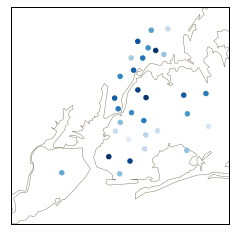

In [76]:
import mpl_toolkits
from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='h'
)

m.drawmapboundary(fill_color='#FFFFFF')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()
m.scatter(x=longitudes, y=latitudes, s=20, zorder=2, latlon=True, c=districts['saf_s_11'], cmap='Blues')

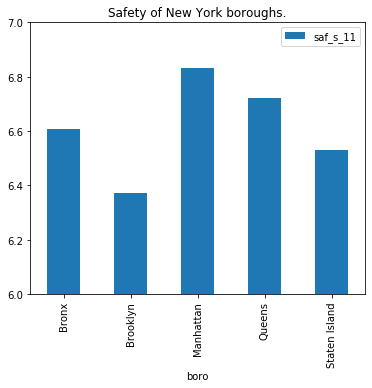

In [19]:
boroughs = combined.groupby('boro').agg(numpy.mean)
boroughs.head()
boroughs.plot(y='saf_s_11', kind='bar', figsize=(6, 5), title='Safety of New York boroughs.', ylim=(6, 7))

According to map and average safety rating Brooklyn has the low safety rating, whereas Upper Manhattan and parts of Queens and Bronx have high safety rating.

# Racial differences in SAT scores

There are a few columns that indicate the percentage of each race at a given school:

* white_per
* asian_per
* black_per
* hispanic_per

We investigate difference in SAT score for all races in dataset. Let's make a plot of the correlations between the race columns and *sat_score*.

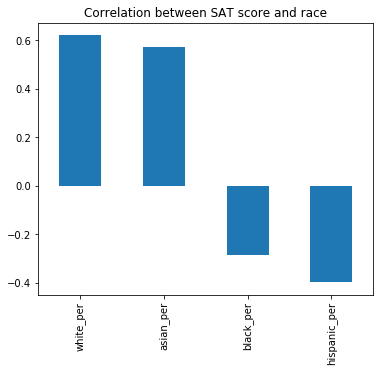

In [20]:
races = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
races_correlations = correlations.loc[races]

races_correlations.plot(x=races_correlations.values, y=races_correlations.index, kind='bar', figsize=(6, 5), title='Correlation between SAT score and race')

As we can see, there is a strong positive correlation between SAT score and percent of white (white_per) and asian (asian_per) and strong negative correlation between SAT score and percent of black (black_per) and hispanic (hispanic_per). This tells us about unfairness of that test.

Then we explore relation between schools with low SAT score and percent of hispanic students.

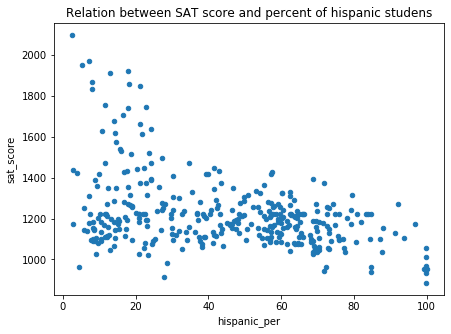

In [24]:
combined.plot(x='hispanic_per', y='sat_score', kind='scatter', figsize=(7, 5), title='Relation between SAT score and percent of hispanic studens')

We see a strong relationship between hispanic_per and SAT score. 

Let's find out which schools have high percent of hispanic students and schools which have low percent of hispanic studens and high SAT score.

In [35]:
combined_high_hispanic_per = combined[combined['hispanic_per'] >= 95]
combined_high_hispanic_per[['SCHOOL NAME', 'sat_score', 'ell_percent']]

,SCHOOL NAME,sat_score,ell_percent
44,MANHATTAN BRIDGES HIGH SCHOOL,1058.0,72.6
82,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,1174.0,19.6
89,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,1014.0,89.6
125,ACADEMY FOR LANGUAGE AND TECHNOLOGY,951.0,86.6
141,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,934.0,79.9
176,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,970.0,92.9
253,MULTICULTURAL HIGH SCHOOL,887.0,94.6
286,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,951.0,91.3


We search information about these schools in the internet and find out that majority of them dedicated for immigrant Latino students with poor knowledge of English. Percent of English learners (ell_percent) in table above confirms that. For example we provide the overview of one of that schools (International school for liberal arts):

"We nurture our students to become fully functional in both English and their home language, Spanish. They will graduate with the tools necessary to compete in the 21st century..."

That's why SAT results of students of that schools are relatively low - many of them don't even know English well enough.

In [43]:
combined_low_hispanic_per_high_sat = combined[(combined['hispanic_per'] <= 10) & (combined['sat_score'] > 1800)]
combined_low_hispanic_per_high_sat[['SCHOOL NAME', 'sat_score', 'ell_percent', 'hispanic_per', 'white_per', 'asian_per', 'black_per']]

,SCHOOL NAME,sat_score,ell_percent,hispanic_per,white_per,asian_per,black_per
37,STUYVESANT HIGH SCHOOL,2096.0,0.0,2.4,23.7,72.1,1.2
151,BRONX HIGH SCHOOL OF SCIENCE,1969.0,0.1,7.2,25.4,63.5,3.5
187,BROOKLYN TECHNICAL HIGH SCHOOL,1833.0,0.1,7.9,21.3,60.3,10.2
327,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,1868.0,0.2,7.9,6.7,74.4,10.5
356,STATEN ISLAND TECHNICAL HIGH SCHOOL,1953.0,0.1,5.3,61.3,31.8,1.1


We search information about these schools in the internet and find out that majority of them specialized in science and technology, provide high quality education, dedicated to preparing students for college and career and only admit students who pass an entrance exam.

As a result students of that schools has a high SAT score.

# Gender differences in SAT scores

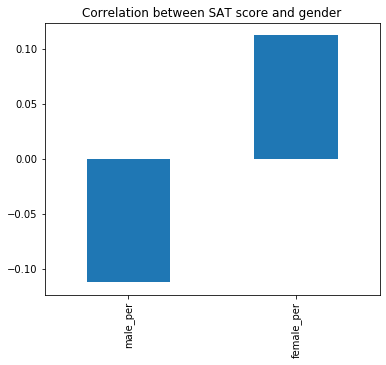

In [45]:
gender = ['male_per', 'female_per']
gender_correlations = correlations.loc[gender]

gender_correlations.plot(x=gender_correlations.values, y=gender_correlations.index, kind='bar', figsize=(6, 5), title='Correlation between SAT score and gender')

Female gender has a weak positive correlation with SAT score while male gender has weak negative correlation with SAT score. That tells us that female students have a tendency to learn a slightly better than male students.

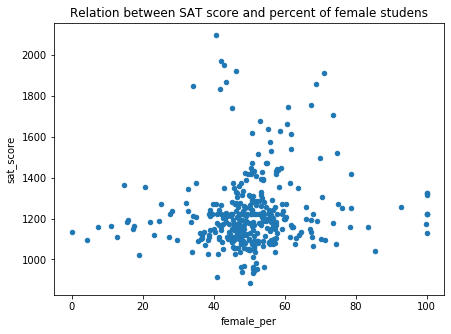

In [46]:
combined.plot(x='female_per', y='sat_score', kind='scatter', figsize=(7, 5), title='Relation between SAT score and percent of female studens')

According to plot we don't see any strong correlation between SAT score and female students percent.

In [51]:
combined_high_female_per_high_sat = combined[(combined['female_per'] >= 60) & (combined['sat_score'] > 1700)]
combined_high_female_per_high_sat[['SCHOOL NAME', 'sat_score', 'female_per']]

,SCHOOL NAME,sat_score,female_per
5,BARD HIGH SCHOOL EARLY COLLEGE,1856.0,68.7
26,ELEANOR ROOSEVELT HIGH SCHOOL,1758.0,67.5
60,BEACON HIGH SCHOOL,1744.0,61.0
61,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,1707.0,73.6
302,TOWNSEND HARRIS HIGH SCHOOL,1910.0,71.1


Schools from table above are liberal arts schools with high academic standards.

# AP exams and SAT scores relation

In [56]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']

In [57]:
combined['ap_per'].head()

0    0.305756
1    0.098985
2    0.031773
3    0.351577
4    0.158091
Name: ap_per, dtype: float64

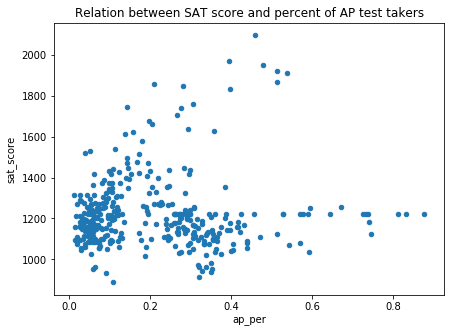

In [59]:
combined.plot(x='ap_per', y='sat_score', kind='scatter', figsize=(7, 5), title='Relation between SAT score and percent of AP test takers')

In [68]:
combined_high_sat_score = combined[combined['sat_score'] > 1300]
combined_low_sat_score = combined[combined['sat_score'] <= 1300]
combined_high_sat_score_corr = combined_high_sat_score.corr()
combined_low_sat_score_corr = combined_low_sat_score.corr()

Correlation between AP test takers and SAT score for schools with high SAT score (> 1300)

In [69]:
combined_high_sat_score_corr.loc['sat_score', 'ap_per']

0.7244882289593124

Correlation between AP test takers and SAT score for schools with low SAT score (< 1300)

In [70]:
combined_low_sat_score_corr.loc['sat_score', 'ap_per']

-0.04333512849570876

We see two different tendencies on plot and correlation compute results. One tendency works for schools with low SAT score (< 1300) and shows us that there are no correlation between percent of AP test takers and SAT score. 
Second tendency is opposite to first, it works for schools with high SAT score (> 1300) and demonstrate strong correlation between SAT score and number of AP takers.

Second tendency could be explained by both high level of knowledge of students who enroll the schools with high average SAT score and high price of education in that schools. So students are interested and able to participate in AP tests.